# **BUSINESS ANALYTICS BACHELOR'S THESIS**

Facultad de Ciencias Económicas y Empresariales \\

### **Wind Power Generation Forecasting Using Transformer-based Time Series Models**


Supervisor: Jenny Alexandra Cifuentes Quintero \\
Author: Teresa Oriol Guerra


Import all necessary libraries

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import random
import seaborn as sns
import pickle

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from itertools import product

from sklearn.ensemble import IsolationForest

from statsmodels.tsa.seasonal import seasonal_decompose

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


## **1. DATA PREPARATION**

### **INTEGRATION**

Import csvs to build the database

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

def load_data(filepaths):
    """Load multiple CSV files from Google Drive and concatenate them into a single DataFrame."""
    dataframes = [pd.read_csv(fp) for fp in filepaths]
    df = pd.concat(dataframes, ignore_index=True)

    # Keep only the relevant columns
    df = df[["MTU (CET/CEST)", "Generation - Wind Onshore [MW] Current / BZN|ES"]]
    df.columns = ["Fecha y Hora", "Generation"]

    return df

# List of file paths in Google Drive
data_files = [
    "/content/drive/MyDrive/ColabNotebooks/TFG ANALYTICS/2020.csv",
    "/content/drive/MyDrive/ColabNotebooks/TFG ANALYTICS/2021.csv",
    "/content/drive/MyDrive/ColabNotebooks/TFG ANALYTICS/2022.csv",
    "/content/drive/MyDrive/ColabNotebooks/TFG ANALYTICS/2023.csv",
    "/content/drive/MyDrive/ColabNotebooks/TFG ANALYTICS/2024.csv"
]

df = load_data(data_files)

Mounted at /content/drive


In [ ]:
df

,Fecha y Hora,Generation
0,01.01.2020 00:00 - 01.01.2020 01:00,1557.0
1,01.01.2020 01:00 - 01.01.2020 02:00,1614.0
2,01.01.2020 02:00 - 01.01.2020 03:00,1677.0
3,01.01.2020 03:00 - 01.01.2020 04:00,1723.0
4,01.01.2020 04:00 - 01.01.2020 05:00,1674.0
...,...,...
112467,31.12.2024 22:45 - 31.12.2024 23:00,2408.0
112468,31.12.2024 23:00 - 31.12.2024 23:15,2672.0
112469,31.12.2024 23:15 - 31.12.2024 23:30,2706.0
112470,31.12.2024 23:30 - 31.12.2024 23:45,2746.0


### **CHANGE TO HOURLY DATA**

We have identified that as of may 24th 2022, the data starts to be posted every 15 minutes. Therefore, let's edit this so that the values for those 4 quarter hours are added together and aggregated as a single 1h period observation.

First: we separate the "Fecha y Hora" column to remove the second part of the text string, since we will only focus on the start time.

In [ ]:
df['Fecha y Hora'] = df['Fecha y Hora'].str.split(' - ').str[0]

Second: we make sure that the variables are in the correct format date time and generation as numeric variable

In [ ]:
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d.%m.%Y %H:%M')

Third: we correct the data that is divided by 1/4 hour, substituting those numbers by the start time in point (00) and making the average generation as the final value of that hour (MW).

In [ ]:
df['Fecha y Hora'] = df['Fecha y Hora'].dt.floor('h')
df_agrupado = df.groupby('Fecha y Hora', as_index=False)['Generation'].mean()

We now make sure that the data is correctly displayed hourly

In [ ]:
df_agrupado

,Fecha y Hora,Generation
0,2020-01-01 00:00:00,1557.00
1,2020-01-01 01:00:00,1614.00
2,2020-01-01 02:00:00,1677.00
3,2020-01-01 03:00:00,1723.00
4,2020-01-01 04:00:00,1674.00
...,...,...
43843,2024-12-31 19:00:00,1856.75
43844,2024-12-31 20:00:00,2166.00
43845,2024-12-31 21:00:00,2314.75
43846,2024-12-31 22:00:00,2326.50


### **RESTRUCTURE TIME COLUMNS**

Next we divide the Date and Time column in two.

In [ ]:
# hay que reconvertirla en str para separarla
df_agrupado['Fecha y Hora'] = df_agrupado['Fecha y Hora'].astype(str)

# Separar columnas de fecha y hora
df_agrupado[['Fecha', 'Hora']] = df_agrupado['Fecha y Hora'].str.split(' ', n=1, expand=True)

df_final = df_agrupado[['Fecha y Hora', 'Fecha', 'Hora', 'Generation']]

In [ ]:
# retomamos el formato de fecha y hora (aunque ahora por separado)
df_final['Fecha'] = pd.to_datetime(df_final['Fecha']).dt.date
df_final['Hora'] = pd.to_datetime(df_final['Hora'], format='%H:%M:%S').dt.time

In [ ]:
df_final

,Fecha y Hora,Fecha,Hora,Generation
0,2020-01-01 00:00:00,2020-01-01,00:00:00,1557.00
1,2020-01-01 01:00:00,2020-01-01,01:00:00,1614.00
2,2020-01-01 02:00:00,2020-01-01,02:00:00,1677.00
3,2020-01-01 03:00:00,2020-01-01,03:00:00,1723.00
4,2020-01-01 04:00:00,2020-01-01,04:00:00,1674.00
...,...,...,...,...
43843,2024-12-31 19:00:00,2024-12-31,19:00:00,1856.75
43844,2024-12-31 20:00:00,2024-12-31,20:00:00,2166.00
43845,2024-12-31 21:00:00,2024-12-31,21:00:00,2314.75
43846,2024-12-31 22:00:00,2024-12-31,22:00:00,2326.50


In [ ]:
print(df_final.dtypes)

Fecha y Hora     object
Fecha            object
Hora             object
Generation      float64
dtype: object


In [ ]:
# if we want to download as excel
#df_final.to_excel('df_final.xlsx', index=False)

### **MISSING VALUES**

In [ ]:
# Check for missing values
missing_values = df_final.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
Fecha y Hora    0
Fecha           0
Hora            0
Generation      6
dtype: int64


In [ ]:
missing_dates = df_final[df_final["Generation"].isnull()]["Fecha y Hora"]
missing_dates

,Fecha y Hora
2114,2020-03-29 02:00:00
10850,2021-03-28 02:00:00
19586,2022-03-27 02:00:00
28322,2023-03-26 02:00:00
37226,2024-03-31 02:00:00
38736,2024-06-02 00:00:00


There are 6 null values that need to be filled. Linera interpolation will be applied to fill these. this method calculated missing values with the man of the two closest values (the one before and the one right after).

In [ ]:
df_final["Generation"] = df_final["Generation"].interpolate(method='linear')

It is checked that there are no missing dates after interpolation of the values



In [ ]:
missing_dates_after_interpolation = df_final[df_final["Generation"].isnull()]["Fecha y Hora"]
missing_dates_after_interpolation

,Fecha y Hora


In [ ]:
# Fill missing values using the average of previous and next values
df_final["Generation"] = df_final["Generation"].interpolate(method='linear')

## **2. EXPLORATORY DATA ANALYSIS**

### **DATASET CHARACTERISTICS AND STATISTICS**

What does the dataset look like?

In [ ]:
print(f"Dataset Shape: {df_final.shape}")
print("Summary Statistics:")
print(df_final.describe())

Dataset Shape: (43848, 4)
Summary Statistics:
         Generation
count  43848.000000
mean    6661.099209
std     3867.566633
min      196.000000
25%     3587.437500
50%     5943.000000
75%     9119.000000
max    20321.000000


Plot the time series of 'Generation'


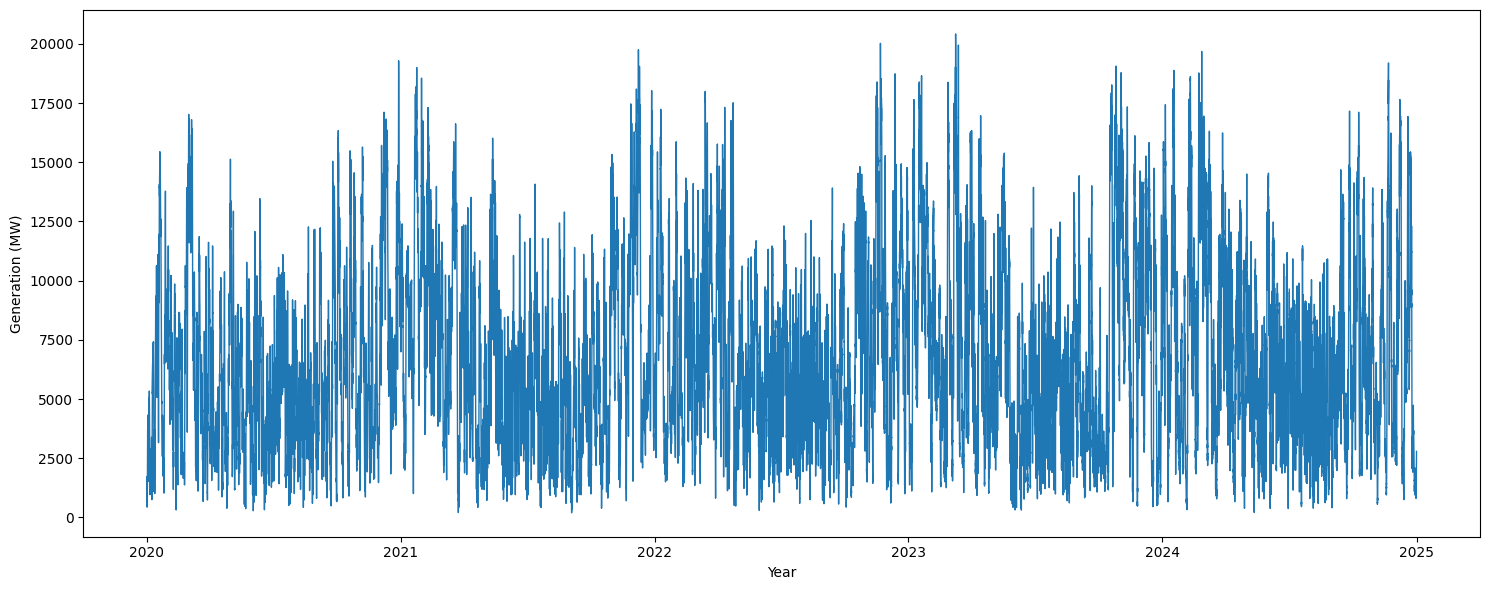

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['Fecha y Hora'], df['Generation'], linewidth=1)
plt.xlabel('Year')
plt.ylabel('Generation (MW)')
plt.grid(False)
plt.tight_layout()
plt.show()

The dataset has 43848 observations

We are going to print an histogram to see how the observations are distributed along the possible values

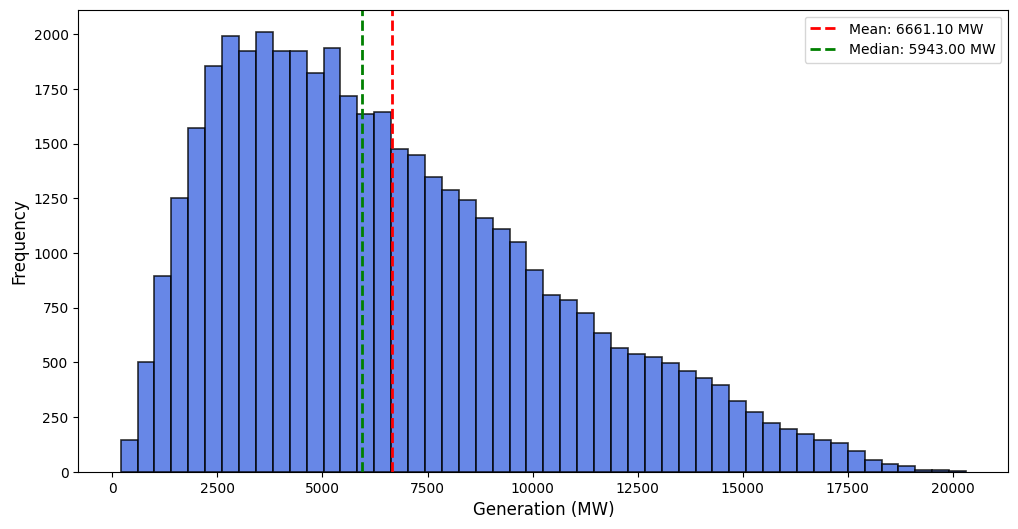

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df_final["Generation"], bins=50, color='royalblue', alpha=0.8, edgecolor='black', linewidth=1.2)

plt.xlabel("Generation (MW)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Líneas de referencia para la media y la mediana
mean_value = df_final["Generation"].mean()
median_value = df_final["Generation"].median()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_value:.2f} MW")
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f"Median: {median_value:.2f} MW")

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.grid(False)

plt.show()


### **OUTLIER ANALYSIS**

To identify outliers we use the following function:

In [ ]:
def contar_outliers_iqr(df):
    """
    Counts the number of outliers in each numerical column of a DataFrame
    using the Interquartile Range (IQR) method.

    An outlier is defined as a value that falls below Q1 - 1.5*IQR or above Q3 + 1.5*IQR,
    where Q1 and Q3 are the 25th and 75th percentiles, respectively.

    Args:
        df (pandas.DataFrame): Input DataFrame with one or more numerical columns.

    Returns:
        dict: A dictionary where keys are column names and values are the number of outliers
              detected in that column.
    """
    outliers = {}
    for col in df.select_dtypes(include=['number']):  # Solo columnas numéricas
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lim_inf) | (df[col] > lim_sup)).sum()
    return outliers

# Contar outliers en cada columna
outliers_iqr = contar_outliers_iqr(df_final)
print(outliers_iqr)

{'Generation': np.int64(257)}


<ipython-input-22-fbdce4dc4e5c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Año', y='Generation', data=df_filtered, palette="pastel")


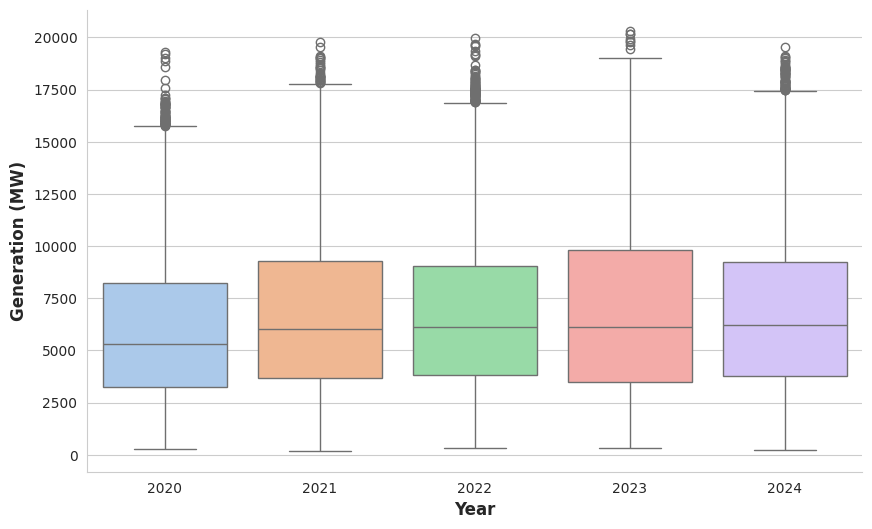

In [ ]:
# Convert 'Fecha' to datetime format and extract the year
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
df_final['Año'] = df_final['Fecha'].dt.year

df_filtered = df_final[df_final['Año'].isin([2020, 2021, 2022, 2023, 2024])]

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Año', y='Generation', data=df_filtered, palette="pastel")

plt.xlabel("Year", fontsize=12, fontweight='bold')
plt.ylabel("Generation (MW)", fontsize=12, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()

plt.show()

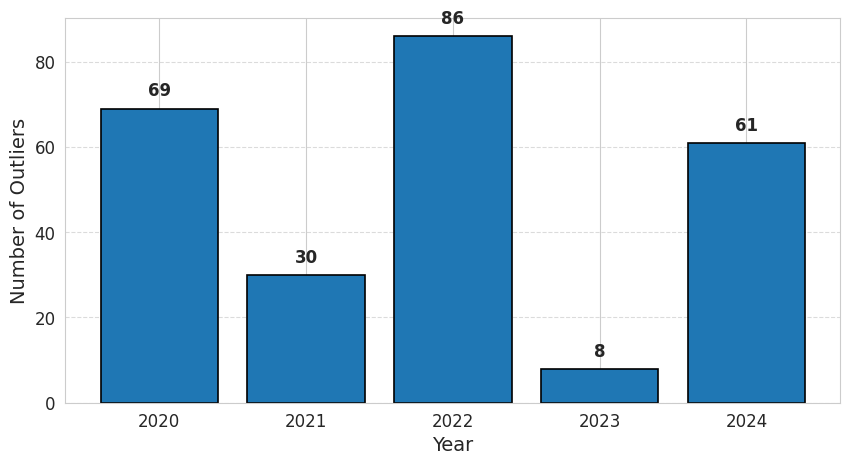

In [ ]:
def detect_outliers_iqr(data, column):
    """
    Identifies and returns the outlier rows in a specific column of a DataFrame
    using the Interquartile Range (IQR) method.

    An outlier is any value below Q1 - 1.5*IQR or above Q3 + 1.5*IQR, where Q1 and Q3
    are the 25th and 75th percentiles of the column, respectively.

    Args:
        data (pandas.DataFrame): The input DataFrame.
        column (str): The name of the column to check for outliers.

    Returns:
        pandas.DataFrame: A subset of the original DataFrame containing only the rows
                          where the specified column has outlier values.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect outliers for each year
outlier_counts = {}
for year in df_final['Año'].unique():
    yearly_data = df_final[df_final['Año'] == year]
    outliers = detect_outliers_iqr(yearly_data, 'Generation')
    outlier_counts[year] = len(outliers)

# Convert to DataFrame
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Año', 'Outlier_Count'])

plt.figure(figsize=(10, 5))
bars = plt.bar(outlier_df['Año'], outlier_df['Outlier_Count'], edgecolor='black', linewidth=1.2)

# Add data labels with a slight offset
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, int(yval), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Adjust labels and style
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Outliers', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### **EXPLAINING "WIND POWER GENERATION" AS A TIME SERIES VARIBLE**

In [ ]:
df_final['Fecha y Hora'] = pd.to_datetime(df_final['Fecha y Hora'])
df_final.set_index('Fecha y Hora', inplace=True)

<ipython-input-25-b4bf6418aa56>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-25-b4bf6418aa56>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-25-b4bf6418aa56>:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-25-b4bf6418aa56>:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


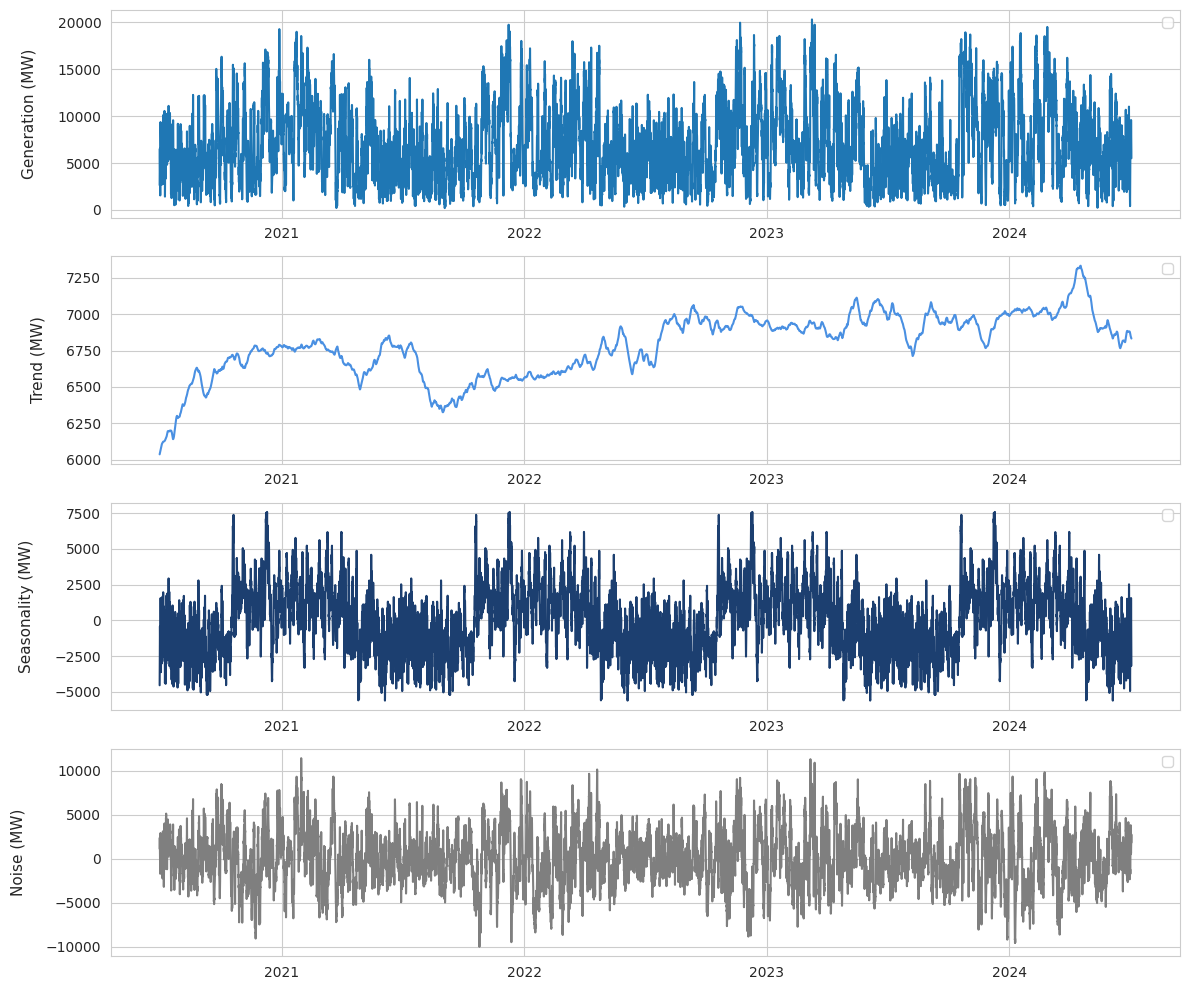

In [ ]:
decomposition = seasonal_decompose(df_final['Generation'], model='additive', period=24*365)

# Crear DataFrame con los componentes descompuestos y conservar las fechas
decomposed_df = pd.DataFrame({
    'Tendencia': decomposition.trend,
    'Estacionalidad': decomposition.seasonal,
    'Ruido': decomposition.resid
}, index=df_final.index)

year_locator = mdates.YearLocator()
year_formatter = mdates.DateFormatter('%Y')

# Obtener el rango donde todas las componentes tienen datos (sin NaNs)
valid_range = decomposed_df.dropna().index

# Filtrar todas las series en ese rango
generation = df_final['Generation'].loc[valid_range]
trend = decomposed_df['Tendencia'].loc[valid_range]
seasonality = decomposed_df['Estacionalidad'].loc[valid_range]
residual = decomposed_df['Ruido'].loc[valid_range]

plt.figure(figsize=(12, 10))

# Generation
plt.subplot(411)
plt.plot(generation.index, generation, color='#1f77b4')
plt.ylabel('Generation (MW)', fontsize=11, labelpad=15)
plt.legend()
plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_formatter)

# Trend
plt.subplot(412)
plt.plot(trend.index, trend, color='#4a90e2')
plt.ylabel('Trend (MW)', fontsize=11, labelpad=15)
plt.legend()
plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_formatter)

# Seasonality
plt.subplot(413)
plt.plot(seasonality.index, seasonality, color='#1c3f70')
plt.ylabel('Seasonality (MW)', fontsize=11, labelpad=15)
plt.legend()
plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_formatter)

# Noise
plt.subplot(414)
plt.plot(residual.index, residual, color='#7f7f7f')
plt.ylabel('Noise (MW)', fontsize=11, labelpad=15)
plt.legend()
plt.gca().xaxis.set_major_locator(year_locator)
plt.gca().xaxis.set_major_formatter(year_formatter)

plt.tight_layout()
plt.show()

## **3. MODELING**

### **PREPROCESSING FOR MODELING**

Preprocessing for modeling:

*   **Drop NA**: Null values were already treated earlier in the pipeline, but we include the dropna() step as a safeguard and for completeness.
*   **Z-score normalization**: The data is normalized to have a mean of 0 and a standard deviation of 1. This helps stabilize the training process and ensures all features are on a similar scale.
*   **Train-test split (70-30)**: The normalized data is split into a training set (70%) and a testing set (30%) to evaluate model performance
*   **Tensor conversion**: The data is converted into PyTorch tensors, which are the required format for feeding data into deep learning models.


In [ ]:
data = df_final[['Generation']].dropna().values
mean, std = data.mean(), data.std()
data = (data - mean) / std
tensor_data = torch.tensor(data, dtype=torch.float32)

train_size = int(0.7 * len(tensor_data))
train_data, test_data = tensor_data[:train_size], tensor_data[train_size:]

Define the needed functions to execute the models

In [ ]:
def create_sequences(data, seq_length):
    """
    Splits a time series into overlapping input-target sequence pairs.

    Args:
        data (array-like): The time series data.
        seq_length (int): The length of each input sequence.

    Returns:
        list of tuples: Each tuple contains (input_sequence, target_sequence),
                        where the target is the input shifted one step ahead.
    """
    sequences = []
    for i in range(len(data) - seq_length):
        seq_input = data[i:i+seq_length]
        seq_target = data[i+1:i+seq_length+1]
        sequences.append((seq_input, seq_target))
    return sequences

In [ ]:
class EarlyStopping:
    """
    Stops training early if validation loss does not improve after a set number of epochs.

    Args:
        patience (int): How many epochs to wait after last improvement.
        min_delta (float): Minimum change in the monitored value to qualify as improvement.
    """
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True

In [ ]:
def calculate_metrics(predictions, targets):
    """
    Calculates regression metrics: MSE, MAE, and MAPE.

    Args:
        predictions (ndarray): Model predictions.
        targets (ndarray): Ground truth values.

    Returns:
        tuple: (MSE, MAE, MAPE)
    """
    mse = np.mean((predictions - targets) ** 2)
    mae = np.mean(np.abs(predictions - targets))
    mape = np.mean(np.abs((targets - predictions) / targets)) * 100
    return mse, mae, mape

In [ ]:
class TransformerModel(nn.Module):
    """
    Defines a Transformer-based model for time series forecasting.

    Args:
        input_dim (int): Number of input features.
        model_dim (int): Dimension of embedding and Transformer layers.
        num_heads (int): Number of attention heads.
        num_layers (int): Number of encoder/decoder layers.
        dropout (float): Dropout rate.
    """
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(model_dim, input_dim)

    def forward(self, src, tgt):
        """
        Forward pass through the model.

        Args:
            src (Tensor): Input sequence.
            tgt (Tensor): Target sequence (shifted).

        Returns:
            Tensor: Model output.
        """
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        output = self.transformer(src, tgt)
        return self.fc_out(output)

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, max_epochs=50):
    """
    Trains the Transformer model and applies early stopping.

    Args:
        model (nn.Module): The Transformer model.
        train_loader (DataLoader): Training data.
        test_loader (DataLoader): Validation/test data.
        criterion: Loss function.
        optimizer: Optimizer.
        max_epochs (int): Maximum number of training epochs.

    Returns:
        tuple: (train_metrics, test_metrics) computed after training ends.
    """
    early_stopping = EarlyStopping(patience=5)
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for src, tgt in train_loader:
            optimizer.zero_grad()
            output = model(src, tgt)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for src, tgt in test_loader:
                output = model(src, tgt)
                loss = criterion(output, tgt)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_val_loss:.4f}")

        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return evaluate_full_metrics(model, train_loader, test_loader)

In [ ]:
def evaluate_full_metrics(model, train_loader, test_loader):
    """
    Evaluates the model on both training and test sets, computing MSE, MAE, and MAPE.
    Assumes data has been normalized and uses global `mean` and `std` for denormalization.

    Args:
        model (nn.Module): The trained model.
        train_loader (DataLoader): Training data.
        test_loader (DataLoader): Testing data.

    Returns:
        tuple: ((train_mse, train_mae, train_mape), (test_mse, test_mae, test_mape))
    """
    def get_outputs(dataloader):
        preds, trues = [], []
        with torch.no_grad():
            for src, tgt in dataloader:
                output = model(src, tgt)[:, -1]
                preds.append(output.numpy().flatten())
                trues.append(tgt[:, -1].numpy().flatten())
        return np.concatenate(preds), np.concatenate(trues)

    model.eval()
    pred_train, true_train = get_outputs(train_loader)
    pred_test, true_test = get_outputs(test_loader)

    pred_train_denorm = (pred_train * std) + mean
    true_train_denorm = (true_train * std) + mean
    pred_test_denorm = (pred_test * std) + mean
    true_test_denorm = (true_test * std) + mean

    train_metrics = calculate_metrics(pred_train_denorm, true_train_denorm)
    test_metrics = calculate_metrics(pred_test_denorm, true_test_denorm)

    return train_metrics, test_metrics

Create the parameter grid and generate random configurations

In [ ]:
model_dims = [16, 32]
num_heads_options = [2, 4, 8]
num_layers_options = [2, 3]
dropouts = [0.1, 0.2, 0.3]
batch_sizes = [16, 32, 64]

grid = []
for model_dim in model_dims:
    for num_heads in num_heads_options:
        if model_dim % num_heads != 0:
            continue
        for num_layers in num_layers_options:
            for dropout in dropouts:
                for batch_size in batch_sizes:
                    grid.append({
                        "model_dim": model_dim,
                        "num_heads": num_heads,
                        "num_layers": num_layers,
                        "dropout": dropout,
                        "batch_size": batch_size
                    })

random.seed(42)
model_configs_20 = random.sample(grid, 20)
model_configs_15 = random.sample(grid, 15)

Next up, the same model configurations will be trained for 12h, 24h and 36h sequence length. The time series will be broken into fixed-length input sequences (seq_length) to create input-output pairs. This will allow the Transformer model to learn from temporal patterns and make predictions based on previous values.


### **TRANSFORMER MODEL MODEL CONFIGURATIONS WITH SEQ_LENGTH 12H**

In [ ]:
# Ejecución por seq_length 12
seq_length_12 = 12
results_12h = {}
for i, config in enumerate(model_configs_20):
    print(f"\nTraining Model {i+1} with Config: {config}")

    train_sequences = create_sequences(train_data, seq_length_12)
    test_sequences = create_sequences(test_data, seq_length_12)
    train_loader = DataLoader(train_sequences, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_sequences, batch_size=config["batch_size"], shuffle=False)

    model = TransformerModel(1, config["model_dim"], config["num_heads"], config["num_layers"], config["dropout"])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())  # ← Default Adam with default lr=0.001

    train_metrics, test_metrics = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)

    results_12h[f"Model_{i+1}"] = {
        "config": config,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics
    }

# Show results
print("RESULTS FOR 12H SEQUENCE LENGTH")
for name, res in results_12h.items():
    print(f"\n{name} Config: {res['config']}")
    print(f"Train -> MSE: {res['train_metrics'][0]:.4f}, MAE: {res['train_metrics'][1]:.4f}, MAPE: {res['train_metrics'][2]:.2f}%")
    print(f"Test  -> MSE: {res['test_metrics'][0]:.4f}, MAE: {res['test_metrics'][1]:.4f}, MAPE: {res['test_metrics'][2]:.2f}%")

with open("results_seq12.pkl", "wb") as f:
    pickle.dump(results_12h, f)

print("Diccionario de resultados guardado en 'results_seq12.pkl'")



Training Model 1 with Config: {'model_dim': 32, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.1, 'batch_size': 16}
Epoch 1, Train Loss: 0.0102, Test Loss: 0.0004
Epoch 2, Train Loss: 0.0021, Test Loss: 0.0003
Epoch 3, Train Loss: 0.0010, Test Loss: 0.0007
Epoch 4, Train Loss: 0.0005, Test Loss: 0.0003
Epoch 5, Train Loss: 0.0005, Test Loss: 0.0009
Epoch 6, Train Loss: 0.0003, Test Loss: 0.0006
Epoch 7, Train Loss: 0.0001, Test Loss: 0.0000
Epoch 8, Train Loss: 0.0002, Test Loss: 0.0000
Epoch 9, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 10, Train Loss: 0.0001, Test Loss: 0.0000
Epoch 11, Train Loss: 0.0002, Test Loss: 0.0000
Epoch 12, Train Loss: 0.0000, Test Loss: 0.0000
Early stopping triggered.

Training Model 2 with Config: {'model_dim': 16, 'num_heads': 2, 'num_layers': 3, 'dropout': 0.2, 'batch_size': 64}
Epoch 1, Train Loss: 0.0409, Test Loss: 0.0041
Epoch 2, Train Loss: 0.0071, Test Loss: 0.0042
Epoch 3, Train Loss: 0.0036, Test Loss: 0.0017
Epoch 4, Train Loss: 0.0021, Test 

### **TRANSFORMER MODEL MODEL CONFIGURATIONS WITH SEQ_LENGTH 24H**

In [ ]:
# Ejecución por seq_length 24
seq_length_24 = 24
results_24h = {}
for i, config in enumerate(model_configs_20):
    print(f"\nTraining Model {i+1} with Config: {config}")

    train_sequences = create_sequences(train_data, seq_length_24)
    test_sequences = create_sequences(test_data, seq_length_24)
    train_loader = DataLoader(train_sequences, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_sequences, batch_size=config["batch_size"], shuffle=False)

    model = TransformerModel(1, config["model_dim"], config["num_heads"], config["num_layers"], config["dropout"])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())  # ← Default Adam with default lr=0.001

    train_metrics, test_metrics = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)

    results_24h[f"Model_{i+1}"] = {
        "config": config,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics
    }

# Show results
print("RESULTS FOR 24H SEQUENCE LENGTH")
for name, res in results_24h.items():
    print(f"\n{name} Config: {res['config']}")
    print(f"Train -> MSE: {res['train_metrics'][0]:.4f}, MAE: {res['train_metrics'][1]:.4f}, MAPE: {res['train_metrics'][2]:.2f}%")
    print(f"Test  -> MSE: {res['test_metrics'][0]:.4f}, MAE: {res['test_metrics'][1]:.4f}, MAPE: {res['test_metrics'][2]:.2f}%")


with open("results_seq24.pkl", "wb") as f:
    pickle.dump(results_24h, f)

print("Diccionario de resultados guardado en 'results_seq24.pkl'")



Training Model 1 with Config: {'model_dim': 32, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.1, 'batch_size': 16}
Epoch 1, Train Loss: 0.0132, Test Loss: 0.0029
Epoch 2, Train Loss: 0.0017, Test Loss: 0.0004
Epoch 3, Train Loss: 0.0010, Test Loss: 0.0002
Epoch 4, Train Loss: 0.0007, Test Loss: 0.0005
Epoch 5, Train Loss: 0.0005, Test Loss: 0.0001
Epoch 6, Train Loss: 0.0003, Test Loss: 0.0000
Epoch 7, Train Loss: 0.0002, Test Loss: 0.0000
Epoch 8, Train Loss: 0.0001, Test Loss: 0.0000
Epoch 9, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 10, Train Loss: 0.0001, Test Loss: 0.0008
Epoch 11, Train Loss: 0.0000, Test Loss: 0.0001
Early stopping triggered.

Training Model 2 with Config: {'model_dim': 16, 'num_heads': 2, 'num_layers': 3, 'dropout': 0.2, 'batch_size': 64}
Epoch 1, Train Loss: 0.0382, Test Loss: 0.0015
Epoch 2, Train Loss: 0.0059, Test Loss: 0.0009
Epoch 3, Train Loss: 0.0029, Test Loss: 0.0004
Epoch 4, Train Loss: 0.0017, Test Loss: 0.0016
Epoch 5, Train Loss: 0.0013, Test L

### **TRANSFORMER MODEL MODEL CONFIGURATIONS WITH SEQ_LENGTH 36H**

In [ ]:
# Ejecución por seq_length 36
seq_length_36 = 36
results_36h = {}
for i, config in enumerate(model_configs_15): # PROBAR CON 20 AHORA QUE ES OTRO OPTIMIZARDOR
    print(f"\nTraining Model {i+1} with Config: {config}")

    train_sequences = create_sequences(train_data, seq_length_36)
    test_sequences = create_sequences(test_data, seq_length_36)
    train_loader = DataLoader(train_sequences, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_sequences, batch_size=config["batch_size"], shuffle=False)

    model = TransformerModel(1, config["model_dim"], config["num_heads"], config["num_layers"], config["dropout"])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())  # ← Default Adam with default lr=0.001

    train_metrics, test_metrics = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)

    results_36h[f"Model_{i+1}"] = {
        "config": config,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics
    }

# Show results
print("RESULTS FOR 36H SEQUENCE LENGTH")
for name, res in results_36h.items():
    print(f"\n{name} Config: {res['config']}")
    print(f"Train -> MSE: {res['train_metrics'][0]:.4f}, MAE: {res['train_metrics'][1]:.4f}, MAPE: {res['train_metrics'][2]:.2f}%")
    print(f"Test  -> MSE: {res['test_metrics'][0]:.4f}, MAE: {res['test_metrics'][1]:.4f}, MAPE: {res['test_metrics'][2]:.2f}%")

with open("results_seq36.pkl", "wb") as f:
    pickle.dump(results_36h, f)

print("Diccionario de resultados guardado en 'results_seq36.pkl'")


Training Model 1 with Config: {'model_dim': 16, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.3, 'batch_size': 32}
Epoch 1, Train Loss: 0.0159, Test Loss: 0.0003
Epoch 2, Train Loss: 0.0016, Test Loss: 0.0001
Epoch 3, Train Loss: 0.0007, Test Loss: 0.0015
Epoch 4, Train Loss: 0.0004, Test Loss: 0.0004
Epoch 5, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 6, Train Loss: 0.0002, Test Loss: 0.0026
Epoch 7, Train Loss: 0.0003, Test Loss: 0.0000
Early stopping triggered.

Training Model 2 with Config: {'model_dim': 32, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'batch_size': 32}
Epoch 1, Train Loss: 0.0100, Test Loss: 0.0065
Epoch 2, Train Loss: 0.0013, Test Loss: 0.0005
Epoch 3, Train Loss: 0.0007, Test Loss: 0.0004
Epoch 4, Train Loss: 0.0007, Test Loss: 0.0000
Epoch 5, Train Loss: 0.0005, Test Loss: 0.0001
Epoch 6, Train Loss: 0.0003, Test Loss: 0.0007
Epoch 7, Train Loss: 0.0003, Test Loss: 0.0007
Epoch 8, Train Loss: 0.0002, Test Loss: 0.0001
Epoch 9, Train Loss: 0.0002, Test Los

## **4. EVALUATION**

For the evaluation, the LSTM and the GRU model will be trained and tested with the same hyperparameters in order to compare the best ones to the best Transformer model.

### **LSTM & GRU**

#### Necessary funtions for LSTM and GRU modeling

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out)

# EARLY STOPPING
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ENTRENAMIENTO
def train_model(model, train_loader, eval_loader, criterion, optimizer, epochs=5, patience=1):
    early_stopper = EarlyStopping(patience)
    for epoch in range(epochs):
        model.train()
        for src, tgt in train_loader:
            optimizer.zero_grad()
            output = model(src)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()

        eval_loss = evaluate(model, eval_loader, criterion)['mse']
        print(f"Epoch {epoch+1}: Eval MSE={eval_loss:.4f}")

        if early_stopper.step(eval_loss):
            print("Early stopping triggered.")
            break

# EVALUACIÓN
def evaluate(model, dataloader, criterion, mean=0, std=1):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for src, tgt in dataloader:
            output = model(src)
            all_preds.append(output.cpu().numpy())
            all_targets.append(tgt.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    preds = (preds * std) + mean
    targets = (targets * std) + mean

    mse = np.mean((preds - targets) ** 2)
    mae = np.mean(np.abs(preds - targets))
    mape = np.mean(np.abs((preds - targets) / (targets + 1e-8))) * 100

    return {'mse': mse, 'mae': mae, 'mape': mape}

# GRID SEARCH
def grid_search(model_class, tensor_data, input_dim, mean, std):
    model_dims = [16, 32]
    hidden_dims = [1, 2]
    num_layers_options = [2, 3]
    dropouts = [0.1, 0.2]
    batch_sizes = [16, 32]
    seq_lengths = [12, 24, 36]

    best_result = None
    best_model = None
    best_seq_length = None
    best_metrics_train = None
    best_metrics_test = None

    for model_dim, hidden_dim, num_layers, dropout, batch_size, seq_length in product(
        model_dims, hidden_dims, num_layers_options, dropouts, batch_sizes, seq_lengths):

        print(f"Training with: model_dim={model_dim}, hidden_dim={hidden_dim}, "f"num_layers={num_layers}, dropout={dropout}, batch_size={batch_size}, seq_length={seq_length}")

        train_size = int(0.7 * len(tensor_data))
        train_raw = tensor_data[:train_size]
        test_raw = tensor_data[train_size:]

        X_train, y_train = create_sequences_GRU_LSTM(train_raw, seq_length)
        X_test, y_test = create_sequences_GRU_LSTM(test_raw, seq_length)

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        model = model_class(input_dim, model_dim, num_layers, dropout)
        optimizer = optim.Adam(model.parameters())
        criterion = nn.MSELoss()

        train_model(model, train_loader, test_loader, criterion, optimizer)

        metrics_test = evaluate(model, test_loader, criterion, mean, std)
        metrics_train = evaluate(model, train_loader, criterion, mean, std)

        if best_result is None or metrics_test['mse'] < best_result['mse']:
            best_result = metrics_test
            best_model = model
            best_seq_length = seq_length
            best_metrics_train = metrics_train
            best_metrics_test = metrics_test
            best_params = {
                "model_dim": model_dim,
                "hidden_dim": hidden_dim,
                "num_layers": num_layers,
                "dropout": dropout,
                "batch_size": batch_size,
                "seq_length": seq_length
            }


    print(f"Best Model -> MSE: {best_result['mse']:.4f}, MAE: {best_result['mae']:.4f}, "
          f"MAPE: {best_result['mape']:.2f}%, seq_length={best_seq_length}")

    return best_model, best_metrics_train, best_metrics_test, best_seq_length, best_params

In [ ]:
def create_sequences_GRU_LSTM(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+1:i+seq_length+1]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

#### Preprocessing

In [ ]:
data = df_final[['Generation']].dropna().values
mean, std = data.mean(), data.std()
data = (data - mean) / std

In [ ]:
input_dim = 1
tensor_data = torch.tensor(data, dtype=torch.float32)

#### Modeling LSTM and GRU

In [ ]:
# GRID SEARCH para LSTM y GRU
print("----- BUSCANDO MEJOR LSTM -----")
best_lstm, lstm_train_results, lstm_test_results, best_seq_lstm, lstm_params  = grid_search(LSTMModel, tensor_data, input_dim, mean, std)

----- BUSCANDO MEJOR LSTM -----
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=16, seq_length=12
Epoch 1: Eval MSE=0.0119
Epoch 2: Eval MSE=0.0107
Epoch 3: Eval MSE=0.0103
Epoch 4: Eval MSE=0.0103
Epoch 5: Eval MSE=0.0104
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=16, seq_length=24
Epoch 1: Eval MSE=0.0109
Epoch 2: Eval MSE=0.0111
Epoch 3: Eval MSE=0.0101
Epoch 4: Eval MSE=0.0098
Epoch 5: Eval MSE=0.0100
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=16, seq_length=36
Epoch 1: Eval MSE=0.0104
Epoch 2: Eval MSE=0.0100
Epoch 3: Eval MSE=0.0100
Epoch 4: Eval MSE=0.0098
Epoch 5: Eval MSE=0.0099
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=32, seq_length=12
Epoch 1: Eval MSE=0.0130
Epoch 2: Eval MSE=0.0117
Epoch 3: Eval MSE=0.0110
Epoch 4: Eval MSE=0.0107
Epoch 5: Eval MSE=0.0103
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, ba

In [ ]:
print("----- BUSCANDO MEJOR GRU -----")
best_gru, gru_train_results, gru_test_results, best_seq_gru, gru_params = grid_search(GRUModel, tensor_data, input_dim, mean, std)

----- BUSCANDO MEJOR GRU -----
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=16, seq_length=12
Epoch 1: Eval MSE=0.0112
Epoch 2: Eval MSE=0.0116
Epoch 3: Eval MSE=0.0105
Epoch 4: Eval MSE=0.0107
Epoch 5: Eval MSE=0.0103
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=16, seq_length=24
Epoch 1: Eval MSE=0.0113
Epoch 2: Eval MSE=0.0105
Epoch 3: Eval MSE=0.0102
Epoch 4: Eval MSE=0.0098
Epoch 5: Eval MSE=0.0106
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=16, seq_length=36
Epoch 1: Eval MSE=0.0109
Epoch 2: Eval MSE=0.0111
Epoch 3: Eval MSE=0.0099
Epoch 4: Eval MSE=0.0097
Epoch 5: Eval MSE=0.0110
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, batch_size=32, seq_length=12
Epoch 1: Eval MSE=0.0120
Epoch 2: Eval MSE=0.0109
Epoch 3: Eval MSE=0.0107
Epoch 4: Eval MSE=0.0105
Epoch 5: Eval MSE=0.0105
Training with: model_dim=16, hidden_dim=1, num_layers=2, dropout=0.1, bat

The following models will be compared to the best Transformer

In [ ]:
# Función para mostrar resultados
def print_metrics(name, results):
    print(f"{name} -> MSE: {results['mse']:.4f}, MAE: {results['mae']:.4f}, MAPE: {results['mape']:.2f}%")

print("\n MEJOR LSTM:")
print("Hiperparámetros:", lstm_params)
print_metrics("Train", lstm_train_results)
print_metrics("Test", lstm_test_results)

print("\n MEJOR GRU:")
print("Hiperparámetros:", gru_params)
print_metrics("Train", gru_train_results)
print_metrics("Test", gru_test_results)


 MEJOR LSTM:
Hiperparámetros: {'model_dim': 32, 'hidden_dim': 2, 'num_layers': 2, 'dropout': 0.1, 'batch_size': 16, 'seq_length': 36}
Train -> MSE: 116529.3196, MAE: 247.4760, MAPE: 4.76%
Test -> MSE: 143538.8780, MAE: 267.0835, MAPE: 4.88%

 MEJOR GRU:
Hiperparámetros: {'model_dim': 32, 'hidden_dim': 1, 'num_layers': 3, 'dropout': 0.1, 'batch_size': 16, 'seq_length': 36}
Train -> MSE: 118938.9271, MAE: 254.0190, MAPE: 5.17%
Test -> MSE: 144631.4175, MAE: 272.4696, MAPE: 5.28%
